##### ARTI 560 - Computer Vision  
## Image Classification using Transfer Learning - Exercise

### Objective

In this exercise, you will:

1. Select another pretrained model (e.g., VGG16, MobileNetV2, or EfficientNet) and fine-tune it for CIFAR-10 classification.  
   You'll find the pretrained models in **Tensorflow Keras Applications Module**.

2. Before training, inspect the architecture using `model.summary()` and observe:

- Network depth  
- Number of parameters  
- Trainable vs Frozen layers  

3. Then compare its performance with ResNet and the custom CNN.

### Questions:

- Which model achieved the highest accuracy?  
- Which model trained faster?  
- How might the architecture explain the differences?


In [1]:
# Imports
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TF version:", tf.__version__)


TF version: 2.19.0


In [2]:
# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
y_train = y_train.squeeze()
y_test  = y_test.squeeze()

print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_test :", x_test.shape,  "y_test :", y_test.shape)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
x_train: (50000, 32, 32, 3) y_train: (50000,)
x_test : (10000, 32, 32, 3) y_test : (10000,)


In [3]:
# Data augmentation (simple, student-style)
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
    ],
    name="data_augmentation",
)

def count_params_split(model: keras.Model):
    """Return (total, trainable, non_trainable) params."""
    total = model.count_params()
    trainable = int(np.sum([np.prod(v.shape) for v in model.trainable_weights]))
    non_trainable = int(np.sum([np.prod(v.shape) for v in model.non_trainable_weights]))
    return total, trainable, non_trainable

def plot_history(hist, title="Training curve"):
    # lightweight plot helper (no seaborn)
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(hist.history.get("accuracy", []), label="train acc")
    plt.plot(hist.history.get("val_accuracy", []), label="val acc")
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()


In [ ]:
# MobileNetV2 (pretrained) 

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mnet_preprocess

mnet_base = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)
mnet_base.trainable = False  # Freeze backbone first

mnet_model = keras.Sequential(
    [
        layers.Input(shape=(32, 32, 3)),
        data_augmentation,
        layers.Resizing(224, 224, interpolation="bilinear"),
        layers.Lambda(mnet_preprocess, name="preprocess_input_mobilenetv2"),  
        mnet_base,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(10, activation=None)  # logits
    ],
    name="cifar10_mobilenetv2"
)

# Inspect architecture
mnet_model.summary()
print("Backbone total layers:", len(mnet_base.layers))
print("Backbone layers with learnable params (depth):", len([l for l in mnet_base.layers if l.count_params() > 0]))
print("Params (total/trainable/non-trainable):", count_params_split(mnet_model))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "cifar10_mobilenetv2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocess_input_mobilenetv2    │ (None, 224, 224, 3)    │             0 │
│ (Lambda)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Backbone total layers: 154
Backbone layers with learnable params (depth): 104
Params (total/trainable/non-trainable): (2270794, 12810, 2257984)


Epoch 1/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 82s 104ms/step - accuracy: 0.6047 - loss: 1.1525 - val_accuracy: 0.8146 - val_loss: 0.5388 - learning_rate: 0.0010
Epoch 2/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 75s 107ms/step - accuracy: 0.7543 - loss: 0.7096 - val_accuracy: 0.8442 - val_loss: 0.4522 - learning_rate: 0.0010
Epoch 3/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 75s 106ms/step - accuracy: 0.7691 - loss: 0.6564 - val_accuracy: 0.8442 - val_loss: 0.4520 - learning_rate: 0.0010
MobileNetV2 (frozen) test accuracy: 0.8373
MobileNetV2 (frozen) training time: 232.5 sec


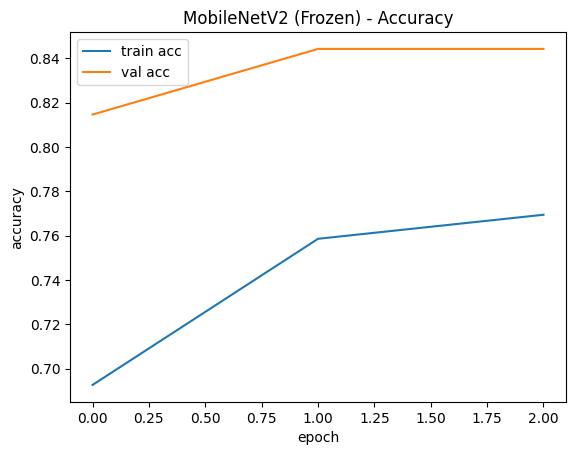

In [ ]:
#Train MobileNetV2 (Frozen)

mnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1),
]

t0 = time.time()
hist_mnet_frozen = mnet_model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=3,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)
mnet_frozen_time = time.time() - t0

mnet_loss_frozen, mnet_acc_frozen = mnet_model.evaluate(x_test, y_test, verbose=0)
print(f"MobileNetV2 (frozen) test accuracy: {mnet_acc_frozen:.4f}")
print(f"MobileNetV2 (frozen) training time: {mnet_frozen_time:.1f} sec")

plot_history(hist_mnet_frozen, "MobileNetV2 (Frozen) - Accuracy")


Trainable layers in backbone: 40 / 154
Epoch 1/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 118s 153ms/step - accuracy: 0.6755 - loss: 0.9480 - val_accuracy: 0.8432 - val_loss: 0.4608
Epoch 2/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 105s 150ms/step - accuracy: 0.7890 - loss: 0.6032 - val_accuracy: 0.8568 - val_loss: 0.4144
Epoch 3/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 105s 150ms/step - accuracy: 0.8159 - loss: 0.5289 - val_accuracy: 0.8670 - val_loss: 0.3798
MobileNetV2 (fine-tuned) test accuracy: 0.8634
MobileNetV2 (fine-tuned) training time: 329.6 sec


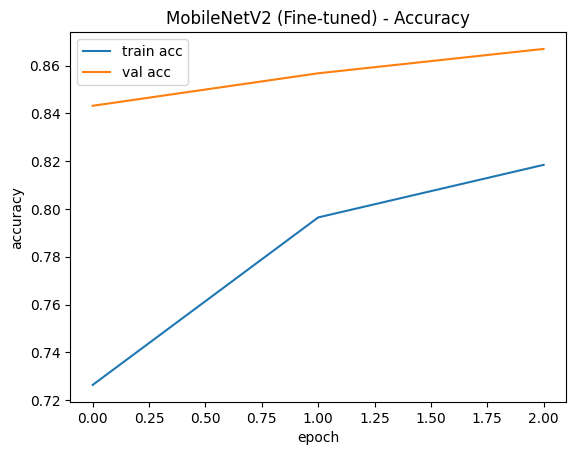

In [ ]:
# Fine-tune last layers of MobileNetV2

mnet_base.trainable = True

# Freeze most layers, unfreeze only the last N layers
N_UNFREEZE = 40
for layer in mnet_base.layers[:-N_UNFREEZE]:
    layer.trainable = False

print("Trainable layers in backbone:", sum(l.trainable for l in mnet_base.layers), "/", len(mnet_base.layers))

mnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

t0 = time.time()
hist_mnet_ft = mnet_model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=3,
    batch_size=64,
    verbose=1
)
mnet_ft_time = time.time() - t0

mnet_loss_ft, mnet_acc_ft = mnet_model.evaluate(x_test, y_test, verbose=0)
print(f"MobileNetV2 (fine-tuned) test accuracy: {mnet_acc_ft:.4f}")
print(f"MobileNetV2 (fine-tuned) training time: {mnet_ft_time:.1f} sec")

plot_history(hist_mnet_ft, "MobileNetV2 (Fine-tuned) - Accuracy")


### Part D) Results from previous notebooks (no re-training)

To follow the lab instruction “compare with ResNet and the custom CNN” **without re-training them here**, we reuse the **saved outputs** from:

- **Lab 1 (custom CNN)**: `lab01-image-classification-cnn-exercise.ipynb`  
- **Lab 2 (ResNet50V2)**: `lab02-image-classification-transfer-learning.ipynb`  

(These accuracies were extracted from the outputs already stored in the provided notebooks.)


In [27]:
# Loaded results (accuracy + training time in seconds)

# Custom CNN (Lab 1)
cnn_acc = 0.9095
cnn_train_time = 146.0

# ResNet50V2 (Lab 2 baseline)
rnet_acc_frozen = 0.8758000135421753
rnet_frozen_time = 550.0

rnet_acc_ft = 0.9161999821662903
rnet_ft_time = 644.0

print("Loaded ")
print("Custom CNN (Lab 1):", cnn_acc, "| time:", cnn_train_time)
print("ResNet50V2 (frozen):", rnet_acc_frozen, "| time:", rnet_frozen_time)
print("ResNet50V2 (fine-tuned):", rnet_acc_ft, "| time:", rnet_ft_time)

Loaded 
Custom CNN (Lab 1): 0.9095 | time: 146.0
ResNet50V2 (frozen): 0.8758000135421753 | time: 550.0
ResNet50V2 (fine-tuned): 0.9161999821662903 | time: 644.0


In [ ]:
# Comparison table

import pandas as pd

results = pd.DataFrame([
    {"Model": "Custom CNN (Lab 1)", "Test Acc": cnn_acc, "Train Time (sec)": cnn_train_time},
    {"Model": "ResNet50V2 (frozen)", "Test Acc": rnet_acc_frozen, "Train Time (sec)": rnet_frozen_time},
    {"Model": "ResNet50V2 (fine-tuned)", "Test Acc": rnet_acc_ft, "Train Time (sec)": rnet_ft_time},
    {"Model": "MobileNetV2 (frozen, pretrained)", "Test Acc": mnet_acc_frozen, "Train Time (sec)": mnet_frozen_time},
    {"Model": "MobileNetV2 (fine-tuned, pretrained)", "Test Acc": mnet_acc_ft, "Train Time (sec)": mnet_ft_time},
]).sort_values(by="Test Acc", ascending=False)

results

,Model,Test Acc,Train Time (sec)
2,ResNet50V2 (fine-tuned),0.9162,644.000000
0,Custom CNN (Lab 1),0.9095,146.000000
1,ResNet50V2 (frozen),0.8758,550.000000
4,"MobileNetV2 (fine-tuned, pretrained)",0.8634,329.562275
3,"MobileNetV2 (frozen, pretrained)",0.8373,232.468836


In [28]:

#  Answers (Q1, Q2, Q3)

best_row = results.loc[results["Test Acc"].idxmax()]

print("1) Which model achieved the highest accuracy?")
print(f"   -> {best_row['Model']} (Test Acc = {best_row['Test Acc']:.4f})")

fastest_row = results.loc[results["Train Time (sec)"].idxmin()]
print("\n2) Which model trained faster?")
print(f"   -> {fastest_row['Model']} (Time = {fastest_row['Train Time (sec)']:.1f} sec)")

print("\n3) How might the architecture explain the differences?")
print(" - ResNet50V2 is deeper/heavier → usually higher capacity but slower.")
print(" - MobileNetV2 is lightweight (depthwise separable conv) → faster with competitive accuracy.")
print(" - Fine-tuning unfreezes more weights → often improves accuracy but increases training time.")
print(" - IMPORTANT: Pretrained backbones require their own preprocess_input before the backbone.")


1) Which model achieved the highest accuracy?
   -> ResNet50V2 (fine-tuned) (Test Acc = 0.9162)

2) Which model trained faster?
   -> Custom CNN (Lab 1) (Time = 146.0 sec)

3) How might the architecture explain the differences?
 - ResNet50V2 is deeper/heavier → usually higher capacity but slower.
 - MobileNetV2 is lightweight (depthwise separable conv) → faster with competitive accuracy.
 - Fine-tuning unfreezes more weights → often improves accuracy but increases training time.
 - IMPORTANT: Pretrained backbones require their own preprocess_input before the backbone.
